<a href="https://colab.research.google.com/github/Indu2204/StanfordAudiology-1/blob/main/Codes/Stanford_Audiology_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing packages

In [ ]:
import numpy as np
import dataclasses
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import pandas as pd
import warnings

# Authenticating google spreadsheet

In [ ]:
from google.colab import auth
import gspread
from google.auth import default  #autenticating to google
auth.authenticate_user()
creds, _ = default()
gc = gspread.authorize(creds)

# Importing the dataset from google spreadsheet

In [ ]:
"""
Change is required in the url. Open the spreadsheet mfb raw audio and copy 
the link from the address bar. The gid code in the url is unique.
"""
worksheet = gc.open_by_url('https://docs.google.com/spreadsheets/d/119_-qrfzGXwV1YBUJdBzvtAQTZnl-xwN7hD9FK5SWfU/edit#gid=84023254').sheet1 #get_all_values gives a list of rows
rows = worksheet.get_all_values()

In [ ]:
# Rename duplicate column name. (Data appears identical, so probably a mistake)
lbone2000_indices = [i for i in range(len(rows[0])) if rows[0][i] == 'LBone2000']
rows[0][lbone2000_indices[1]] = 'LBone2000Dupe'

In [ ]:
# Convert spaces in all column names to _ so they can be field names.
column_names = [s.replace(' ', '_') for s in rows[0]]

In [ ]:
StanfordData = dataclasses.make_dataclass('stanford_data', column_names)

In [ ]:
all_stanford_data = [StanfordData(*rows[i]) for i in range(1, len(rows))]

In [ ]:
from typing import List

def collect_array(sd: List[dataclasses.dataclass], 
                  field_list: List[str],
                  type=np.float32) -> np.ndarray:
  """Collect the data from each field listed in list and return a single
  numpy array with all the data. 

  Args:
    sd: A list of Stanford dataclass objects (holding the audiogram data)
    field_list: A list of column names to extract
    type: The desired data type, should be a NP type or object.
  """
  data = np.zeros((len(sd), len(field_list)), dtype=type)
  for i, r in enumerate(sd):
    for j, f in enumerate(field_list):
      d = r.__getattribute__(f)

      if type==np.float32 or type==np.float64:
        if d == '' or d == 'NR':
          d = np.nan
        else:
          try:
            d = float(d)
          except:   # Last resort
            d = np.nan

      data[i, j] = d
  return data


In [ ]:
# Figure out which rows have missing (NaN) data in them.
def remove_nans(data):
  num_nans_row = np.sum(np.isnan(data), axis=1)
  good_rows = [i for i in range(len(num_nans_row)) if num_nans_row[i] == 0]
  bad_rows = [i for i in range(len(num_nans_row)) if num_nans_row[i] > 0]
  good_data = data[good_rows,:]
  return (good_data,good_rows)

In [ ]:
"""
Identifying the index of rows that have valid age entry as noted 
on the test day
"""
#Collecting the entire column from the main dataframe
age_data = collect_array(all_stanford_data,['AgeAtTestDate']) 

good_age_rows,_ = np.where((age_data >=0) & (age_data <=100))
good_age_data = age_data[good_age_rows]
good_age_data.shape

(76807, 1)

In [ ]:
columns = ['AgeAtTestDate','R250', 'R500', 'R1000', 'R2000', 'R3000', 'R4000', 
           'R6000', 'R8000','L250', 'L500', 'L1000', 'L2000', 'L3000', 'L4000', 
           'L6000', 'L8000', 'RBone500',	'RBone1000',	'RBone2000', 
           'RBone4000', 'LBone500',	'LBone1000',	'LBone2000', 'LBone4000',
           'MonSNR_Score_R', 'Word_Rec_Score_R','MonSNR_Score_L',
           'Word_Rec_Score_L']
data = collect_array(all_stanford_data,columns) 

#Collecting data corresponding to indices with valid age entires
data_final = data[good_age_rows,:]
data_final.shape

(76807, 29)

#Hearing Loss Summary Plots

In [ ]:
hl_right_labels = ['R250', 'R500', 'R1000', 'R2000', 'R3000', 'R4000', 'R6000', 'R8000']

#Collect data corresponding to audiometric frequencies and removing the nan values
hl_right,_ = remove_nans(collect_array(all_stanford_data, hl_right_labels)) 
hl_right_freq =  [float(f.replace('R', '')) for f in hl_right_labels]

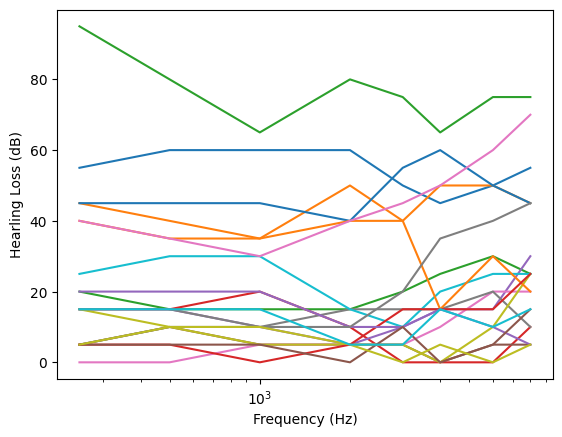

In [ ]:
# Plot the first HL for the first 20 subjects.
plt.semilogx(hl_right_freq,hl_right[:20,:].T);
plt.xlabel("Frequency (Hz)")
plt.ylabel("Hearling Loss (dB)")
plt.show()

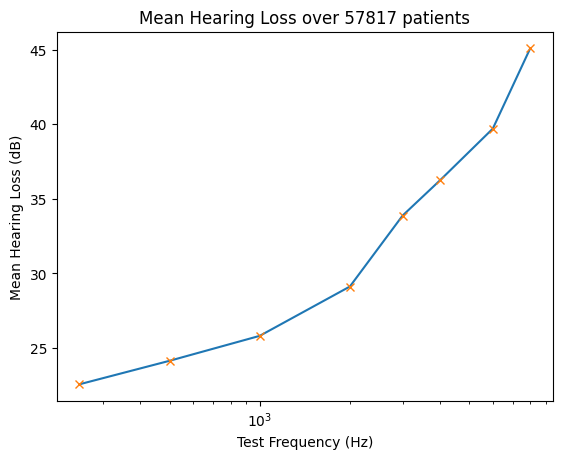

In [ ]:
plt.semilogx(hl_right_freq, np.mean(hl_right, axis=0))
plt.semilogx(hl_right_freq, np.mean(hl_right, axis=0), 'x')
plt.title(f'Mean Hearing Loss over {hl_right.shape[0]} patients')
plt.xlabel('Test Frequency (Hz)')
plt.ylabel('Mean Hearing Loss (dB)');

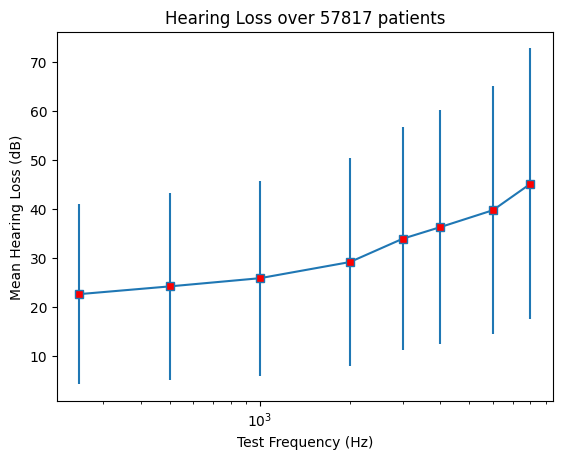

In [ ]:
# plt.plot(hl_labels, np.mean(good_hl, axis=0))
plt.errorbar(hl_right_freq, np.mean(hl_right, axis=0), 
             np.std(hl_right, axis=0),marker = 's',mfc = 'red',
             xlolims = True,xuplims = True)
plt.gca().set_xscale('log')

plt.title(f'Hearing Loss over {hl_right.shape[0]} patients')
plt.xlabel('Test Frequency (Hz)')
plt.ylabel('Mean Hearing Loss (dB)');

#PCA of HL data

In [ ]:
from sklearn.decomposition import PCA

Variance ratio: [0.7944791  0.1176611  0.04255034 0.01897818 0.01004551]


''

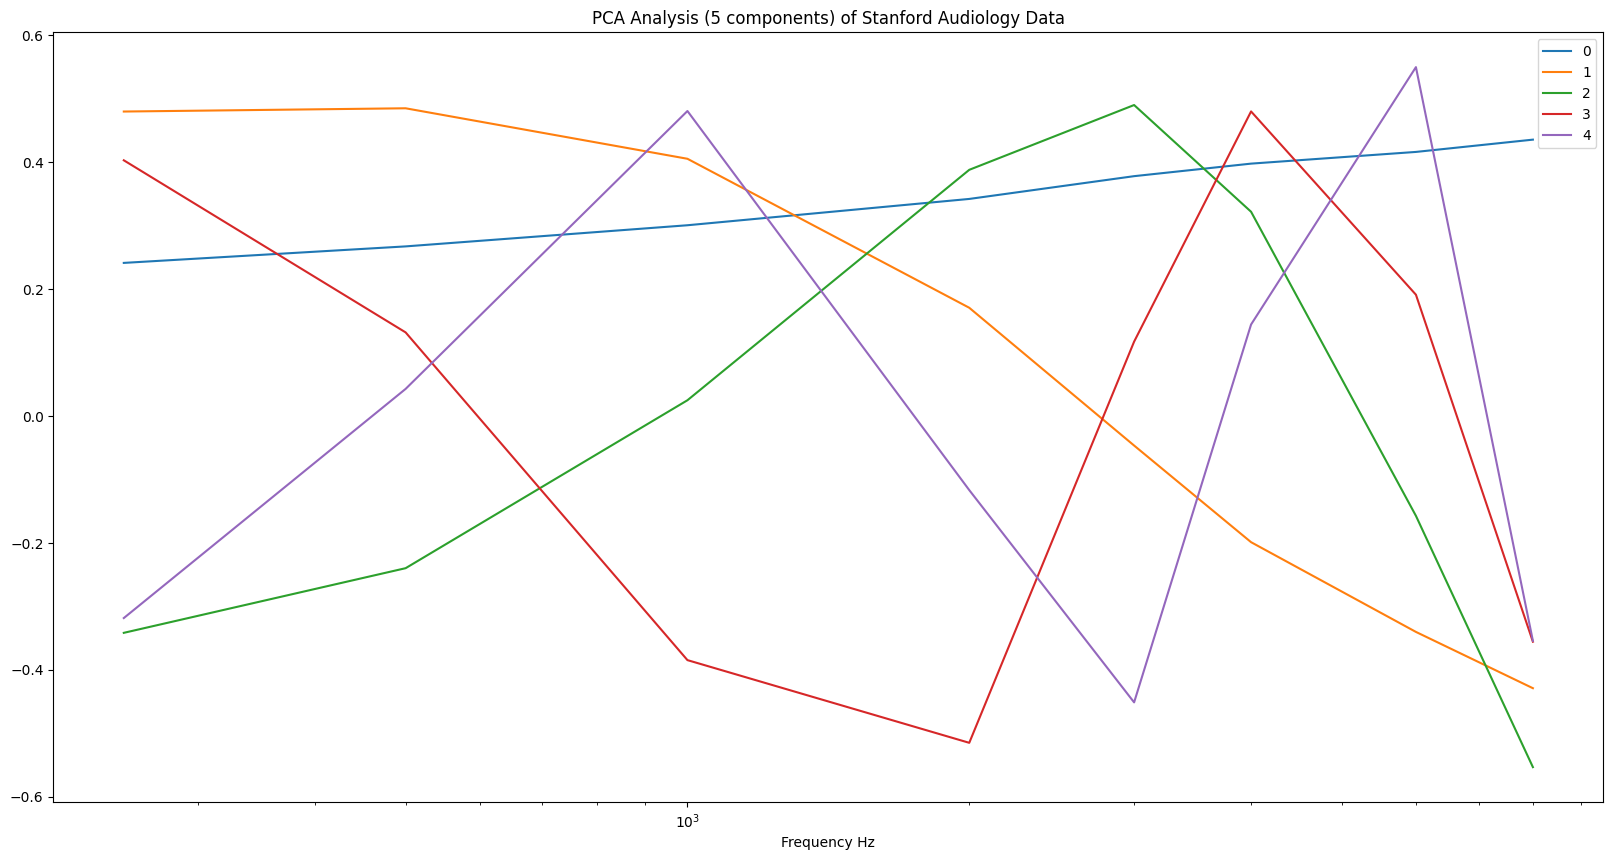

In [ ]:
pca = PCA(n_components=5)
pca.fit(hl_right)
print("Variance ratio:",pca.explained_variance_ratio_)
plt.figure(figsize=(20,10))
plt.semilogx(hl_right_freq,pca.components_.T)
plt.legend([i for i in range(6)])
plt.xlabel(f'Frequency Hz')
plt.title('PCA Analysis (5 components) of Stanford Audiology Data');""

#HL classification

In [ ]:
"""
Reading the dataframes containing HL at audiometric frequencies and 
HL for bone conduction based test to classify the type of hearling loss
"""
df = pd.DataFrame(data_final, columns = columns)

In [ ]:
#Dropping rows with NaN values in columns corresponding to audiometric frequencies
audiometric_freq = ['R250', 'R500', 'R1000', 'R2000', 'R3000', 'R4000', 'R6000', 
                    'R8000','L250', 'L500', 'L1000', 'L2000', 'L3000', 'L4000', 
                    'L6000', 'L8000']
df = df.dropna(subset = audiometric_freq )
df.shape

(53187, 29)

### Do not run

In [ ]:
"""
To calculate different metrics that will be used as criterion for classifying
the hearing loss types
"""
#HFPTA
df_hfpta_R  = df[['R1000', 'R2000', 'R4000']]
df_hfpta_L  = df[['L1000', 'L2000', 'L4000']]
HFPTA_R = np.array(np.nanmean(df_hfpta_R.to_numpy(),axis=1))
HFPTA_L = np.array(np.nanmean(df_hfpta_L.to_numpy(),axis=1))
df.loc[:,'R_HFPTA'] = HFPTA_R
df.loc[:,'L_HFPTA'] = HFPTA_L

# PTA - 500, 1000, 2000 
df_pta_R = df[['R500', 'R1000', 'R2000']]
df_pta_L = df[['L500', 'L1000', 'L2000']]
PTA_R = np.array(np.nanmean(df_pta_R.to_numpy(),axis=1))
PTA_L = np.array(np.nanmean(df_pta_L.to_numpy(),axis=1))
df.loc[:,'R_PTA'] = PTA_R
df.loc[:,'L_PTA'] = PTA_L

#PTA all -  500,1000,2000,4000
df_pta_all_R = df[['R500', 'R1000', 'R2000', 'R4000']]
df_pta_all_L = df[['L500', 'L1000', 'L2000', 'L4000']]
PTA_all_R = np.array(np.nanmean(df_pta_all_R.to_numpy(),axis=1))
PTA_all_L = np.array(np.nanmean(df_pta_all_L.to_numpy(),axis=1))
df.loc[:,'R_PTA_All'] = PTA_all_R
df.loc[:,'L_PTA_All'] = PTA_all_L

#LFPTA -  250, 500,1000
df_lfpta_R = df[['R500', 'R1000']]
df_lfpta_L = df[['L500', 'L1000']]
LFPTA_R = np.array(np.nanmean(df_lfpta_R.to_numpy(),axis=1))
LFPTA_L = np.array(np.nanmean(df_lfpta_L.to_numpy(),axis=1))
df.loc[:,'R_LFPTA'] = LFPTA_R
df.loc[:,'L_LFPTA'] = LFPTA_L

#UHFPTA - 2000, 4000, 80000
df_uhfpta_R = df[['R2000', 'R4000', 'R8000']]
df_uhfpta_L = df[['L2000', 'L4000', 'L8000']]
UHFPTA_R = np.array(np.nanmean(df_uhfpta_R.to_numpy(),axis=1))
UHFPTA_L = np.array(np.nanmean(df_uhfpta_L.to_numpy(),axis=1))
df.loc[:,'R_UHFPTA'] = UHFPTA_R
df.loc[:,'L_UHFPTA'] = UHFPTA_L

#PT Bone conduction modeled
df_pta_BC_mod_R = df[['RBone500', 'RBone1000', 'RBone2000']]
df_pta_BC_mod_L = df[['LBone500', 'LBone1000', 'LBone2000']]
PTA_BC_mod_R = np.array(np.nanmean(df_pta_BC_mod_R.to_numpy(), axis=1))
PTA_BC_mod_L = np.array(np.nanmean(df_pta_BC_mod_L.to_numpy(), axis=1))
df.loc[:,'R_PTA_BC_Mod'] = PTA_BC_mod_R
df.loc[:,'L_PTA_BC_Mod'] = PTA_BC_mod_L

#HFPTA Bone conduction modeled
df_hfpta_BC_mod_R = df[['RBone1000', 'RBone2000','RBone4000']]
df_hfpta_BC_mod_L = df[['LBone1000', 'LBone2000','LBone4000']]
HFPTA_BC_mod_R = np.array(np.nanmean(df_hfpta_BC_mod_R.to_numpy(),axis=1))
HFPTA_BC_mod_L = np.array(np.nanmean(df_hfpta_BC_mod_L.to_numpy(),axis=1))
df.loc[:,'R_HFPTA_BC_Mod'] = HFPTA_BC_mod_R
df.loc[:,'L_HFPTA_BC_Mod'] = HFPTA_BC_mod_L

#BC average of 500, 1, 2, 4
df_hfpta_BC_avg_R = df[['RBone500','RBone1000', 'RBone2000','RBone4000']]
df_hfpta_BC_avg_L = df[['LBone500','LBone1000', 'LBone2000','LBone4000']]
HFPTA_BC_avg_R = np.array(np.nanmean(df_hfpta_BC_avg_R.to_numpy(),axis=1))
HFPTA_BC_avg_L = np.array(np.nanmean(df_hfpta_BC_avg_L.to_numpy(),axis=1))
df.loc[:,'R_PTA_BC_All'] = HFPTA_BC_avg_R
df.loc[:,'L_PTA_BC_All'] = HFPTA_BC_avg_L

# new ABGap
df.loc[:,'R_PTA_ABGap'] = df['R_PTA'] - df['R_PTA_BC_Mod']
df.loc[:,'R_HFPTA_ABGap'] = df['R_HFPTA'] - df['R_HFPTA_BC_Mod']
df.loc[:,'R_PTA_All_ABGap'] = df['R_PTA_All'] - df['R_PTA_BC_All']

df.loc[:,'L_PTA_ABGap'] = df['L_PTA'] - df['L_PTA_BC_Mod']
df.loc[:,'L_HFPTA_ABGap'] = df['L_HFPTA'] - df['L_HFPTA_BC_Mod']
df.loc[:,'L_PTA_All_ABGap'] = df['L_PTA_All'] - df['L_PTA_BC_All']

In [ ]:
#HL Type
#Right
# using the new Modeled BC PTA of 5, 1, 2
conditions_1 = [(df['R_PTA_BC_Mod'] < 25.1) & (df['R_PTA_ABGap'] >= 10) 
                & (df['R_PTA'] > 25), 
                (df['R_PTA_ABGap'] < 10) & (df['R_PTA'] > 25), 
                (df['R_PTA_BC_Mod'] > 25) & (df['R_PTA_ABGap'] >= 10) 
                & (df['R_PTA'] > 25)]
values = ['Conductive','SNHL','Mixed']
df['R_Type_HL_Mod']= np.select(conditions_1, values)
df.loc[df["R_Type_HL_Mod"] == '0' , "R_Type_HL_Mod"] = 'Normal'

# HFPTA of 1 
conditions_2 = [(df['R_HFPTA_BC_Mod'] < 25.1) & (df['R_HFPTA_ABGap'] >= 10) 
              & (df['R_HFPTA'] > 25), 
                (df['R_HFPTA_ABGap'] < 10) & (df['R_HFPTA'] > 25), 
                (df['R_HFPTA_BC_Mod'] > 25) & (df['R_HFPTA_ABGap'] >= 10) 
                & (df['R_HFPTA'] > 25)]
values = ['Conductive','SNHL','Mixed']
df['R_Type_HL_HF'] = np.select(conditions_2, values)
df.loc[df["R_Type_HL_HF"] == '0' , "R_Type_HL_HF"] = 'Normal'

# # PTA of 500 1 2 4
conditions_3 = [(df['R_PTA_BC_All'] < 25.1) & (df['R_PTA_All_ABGap'] >= 10) 
                & (df['R_PTA_All'] > 25), 
                (df['R_PTA_All_ABGap'] < 10) & (df['R_PTA_All'] > 25), 
                (df['R_PTA_BC_All'] > 25) & (df['R_PTA_All_ABGap'] >= 10) 
                & (df['R_PTA_All'] > 25)]
values = ['Conductive','SNHL','Mixed']
df['R_Type_HL_All'] = np.select(conditions_3, values)
df.loc[df["R_Type_HL_All"] == '0' , "R_Type_HL_All"] = 'Normal'

### Hearing loss classification - function

In [ ]:
"""
function that takes in audiometric frequencies and returns the hearling 
loss class
"""
audiometric_freq_1 = ['R250', 'R500', 'R1000', 'R2000', 'R3000', 'R4000', 'R6000', 
                    'R8000','L250', 'L500', 'L1000', 'L2000', 'L3000', 'L4000', 
                    'L6000', 'L8000', 'RBone500','RBone1000','RBone2000',
                    'RBone4000', 'LBone500', 'LBone1000', 'LBone2000',
                    'LBone4000']
"""
I am assuming we pass a set of dataframes corresponding to the audiometric 
frequencies 
"""
def HL_loss_classifier(df):
  """
  To calculate different metrics that will be used as criterion for classifying
  the hearing loss types

  Args:
    df:  dataframe with HL measurements at audiometric frequencies

  Returns:
    df: dataframe with HL classes as a new column
  """
  with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    #HFPTA
    df_hfpta_R  = df[['R1000', 'R2000', 'R4000']]
    df_hfpta_L  = df[['L1000', 'L2000', 'L4000']]
    HFPTA_R = np.array(np.nanmean(df_hfpta_R.to_numpy(),axis=1))
    HFPTA_L = np.array(np.nanmean(df_hfpta_L.to_numpy(),axis=1))
    df.loc[:,'R_HFPTA'] = HFPTA_R
    df.loc[:,'L_HFPTA'] = HFPTA_L

    # PTA - 500, 1000, 2000 
    df_pta_R = df[['R500', 'R1000', 'R2000']]
    df_pta_L = df[['L500', 'L1000', 'L2000']]
    PTA_R = np.array(np.nanmean(df_pta_R.to_numpy(),axis=1))
    PTA_L = np.array(np.nanmean(df_pta_L.to_numpy(),axis=1))
    df.loc[:,'R_PTA'] = PTA_R
    df.loc[:,'L_PTA'] = PTA_L

    #PTA all -  500,1000,2000,4000
    df_pta_all_R = df[['R500', 'R1000', 'R2000', 'R4000']]
    df_pta_all_L = df[['L500', 'L1000', 'L2000', 'L4000']]
    PTA_all_R = np.array(np.nanmean(df_pta_all_R.to_numpy(),axis=1))
    PTA_all_L = np.array(np.nanmean(df_pta_all_L.to_numpy(),axis=1))
    df.loc[:,'R_PTA_All'] = PTA_all_R
    df.loc[:,'L_PTA_All'] = PTA_all_L

    #LFPTA -  250, 500,1000
    df_lfpta_R = df[['R500', 'R1000']]
    df_lfpta_L = df[['L500', 'L1000']]
    LFPTA_R = np.array(np.nanmean(df_lfpta_R.to_numpy(),axis=1))
    LFPTA_L = np.array(np.nanmean(df_lfpta_L.to_numpy(),axis=1))
    df.loc[:,'R_LFPTA'] = LFPTA_R
    df.loc[:,'L_LFPTA'] = LFPTA_L

    #UHFPTA - 2000, 4000, 80000
    df_uhfpta_R = df[['R2000', 'R4000', 'R8000']]
    df_uhfpta_L = df[['L2000', 'L4000', 'L8000']]
    UHFPTA_R = np.array(np.nanmean(df_uhfpta_R.to_numpy(),axis=1))
    UHFPTA_L = np.array(np.nanmean(df_uhfpta_L.to_numpy(),axis=1))
    df.loc[:,'R_UHFPTA'] = UHFPTA_R
    df.loc[:,'L_UHFPTA'] = UHFPTA_L

    #PT Bone conduction modeled
    df_pta_BC_mod_R = df[['RBone500', 'RBone1000', 'RBone2000']]
    df_pta_BC_mod_L = df[['LBone500', 'LBone1000', 'LBone2000']]
    PTA_BC_mod_R = np.array(np.nanmean(df_pta_BC_mod_R.to_numpy(), axis=1))
    PTA_BC_mod_L = np.array(np.nanmean(df_pta_BC_mod_L.to_numpy(), axis=1))
    df.loc[:,'R_PTA_BC_Mod'] = PTA_BC_mod_R
    df.loc[:,'L_PTA_BC_Mod'] = PTA_BC_mod_L

    #HFPTA Bone conduction modeled
    df_hfpta_BC_mod_R = df[['RBone1000', 'RBone2000','RBone4000']]
    df_hfpta_BC_mod_L = df[['LBone1000', 'LBone2000','LBone4000']]
    HFPTA_BC_mod_R = np.array(np.nanmean(df_hfpta_BC_mod_R.to_numpy(),axis=1))
    HFPTA_BC_mod_L = np.array(np.nanmean(df_hfpta_BC_mod_L.to_numpy(),axis=1))
    df.loc[:,'R_HFPTA_BC_Mod'] = HFPTA_BC_mod_R
    df.loc[:,'L_HFPTA_BC_Mod'] = HFPTA_BC_mod_L

    #BC average of 500, 1, 2, 4
    df_hfpta_BC_avg_R = df[['RBone500','RBone1000', 'RBone2000','RBone4000']]
    df_hfpta_BC_avg_L = df[['LBone500','LBone1000', 'LBone2000','LBone4000']]
    HFPTA_BC_avg_R = np.array(np.nanmean(df_hfpta_BC_avg_R.to_numpy(),axis=1))
    HFPTA_BC_avg_L = np.array(np.nanmean(df_hfpta_BC_avg_L.to_numpy(),axis=1))
    df.loc[:,'R_PTA_BC_All'] = HFPTA_BC_avg_R
    df.loc[:,'L_PTA_BC_All'] = HFPTA_BC_avg_L

    # new ABGap
    df.loc[:,'R_PTA_ABGap'] = df['R_PTA'] - df['R_PTA_BC_Mod']
    df.loc[:,'R_HFPTA_ABGap'] = df['R_HFPTA'] - df['R_HFPTA_BC_Mod']
    df.loc[:,'R_PTA_All_ABGap'] = df['R_PTA_All'] - df['R_PTA_BC_All']

    df.loc[:,'L_PTA_ABGap'] = df['L_PTA'] - df['L_PTA_BC_Mod']
    df.loc[:,'L_HFPTA_ABGap'] = df['L_HFPTA'] - df['L_HFPTA_BC_Mod']
    df.loc[:,'L_PTA_All_ABGap'] = df['L_PTA_All'] - df['L_PTA_BC_All']

    #HL Type
    #Right
    # using the new Modeled BC PTA of 5, 1, 2
    conditions_1 = [(df['R_PTA_BC_Mod'] < 25.1) & (df['R_PTA_ABGap'] >= 10) & (df['R_PTA'] > 25), 
                    (df['R_PTA_ABGap'] < 10) & (df['R_PTA'] > 25), 
                    (df['R_PTA_BC_Mod'] > 25) & (df['R_PTA_ABGap'] >= 10) & (df['R_PTA'] > 25)]
    values = ['Conductive','SNHL','Mixed']
    df['R_Type_HL_Mod']= np.select(conditions_1, values)
    df.loc[df["R_Type_HL_Mod"] == '0' , "R_Type_HL_Mod"] = 'Normal'

    # HFPTA of 1 
    conditions_2 = [(df['R_HFPTA_BC_Mod'] < 25.1) & (df['R_HFPTA_ABGap'] >= 10) & (df['R_HFPTA'] > 25), 
                    (df['R_HFPTA_ABGap'] < 10) & (df['R_HFPTA'] > 25), 
                    (df['R_HFPTA_BC_Mod'] > 25) & (df['R_HFPTA_ABGap'] >= 10) & (df['R_HFPTA'] > 25)]
    values = ['Conductive','SNHL','Mixed']
    df['R_Type_HL_HF'] = np.select(conditions_2, values)
    df.loc[df["R_Type_HL_HF"] == '0' , "R_Type_HL_HF"] = 'Normal'

    # # PTA of 500 1 2 4
    conditions_3 = [(df['R_PTA_BC_All'] < 25.1) & (df['R_PTA_All_ABGap'] >= 10) & (df['R_PTA_All'] > 25), 
                    (df['R_PTA_All_ABGap'] < 10) & (df['R_PTA_All'] > 25), 
                    (df['R_PTA_BC_All'] > 25) & (df['R_PTA_All_ABGap'] >= 10) & (df['R_PTA_All'] > 25)
                    ]
    values = ['Conductive','SNHL','Mixed']
    df['R_Type_HL_All'] = np.select(conditions_3, values)
    df.loc[df["R_Type_HL_All"] == '0' , "R_Type_HL_All"] = 'Normal'
  return df

In [ ]:
def HL_plot(df):
  """
  df is the dataframe that contains hearing Threshold class as a column
  """
  df_normal = df.loc[df['R_Type_HL_All'] == 'Normal']
  df_snhl = df.loc[df['R_Type_HL_All'] == 'SNHL']
  df_conductive = df.loc[df['R_Type_HL_All'] == 'Conductive']
  df_mixed = df.loc[df['R_Type_HL_All'] == 'Mixed']

  plt.scatter(df_normal['R_PTA_BC_All'], df_normal['R_PTA_All'], color = 'r',alpha = 0.5, label = 'Normal')
  plt.scatter(df_snhl['R_PTA_BC_All'], df_snhl['R_PTA_All'], color = 'b',alpha = 0.5, label = 'SNHL')
  plt.scatter(df_conductive['R_PTA_BC_All'], df_conductive['R_PTA_All'], alpha = 0.5, color = 'g', label = 'Conductive')
  plt.scatter(df_mixed['R_PTA_BC_All'], df_mixed['R_PTA_All'], color = 'black',alpha = 0.5, label = 'Mixed')

  plt.xlabel('Average Bone Conduction Threshold')
  plt.ylabel("Average Air Conduction Threshold")

  plt.legend()
  plt.show()

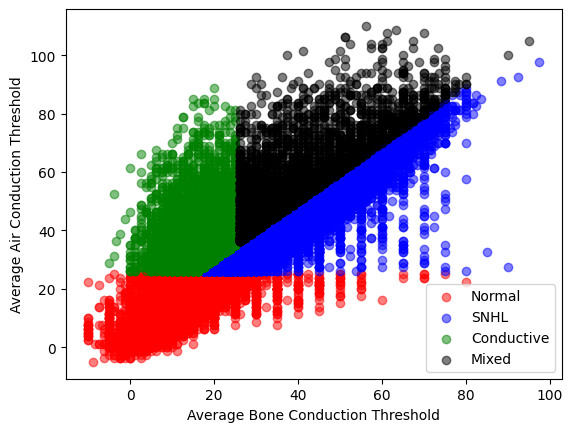

In [ ]:
#With acutal data
data_actual = df.loc[:,audiometric_freq_1]
df_actual = HL_loss_classifier(data_actual)
HL_plot(df_actual)

In [ ]:
df_air_bone = data_actual.loc[data_actual['R_PTA_BC_All'] > data_actual['R_PTA_All']]

In [ ]:
df_air_bone[['R_PTA_BC_All','R_PTA_All','R_Type_HL_All']]

,R_PTA_BC_All,R_PTA_All,R_Type_HL_All
6,7.500000,5.00,Normal
14,20.000000,6.25,Normal
61,30.000000,21.25,Normal
81,7.500000,5.00,Normal
88,2.500000,1.25,Normal
...,...,...,...
76745,65.000000,56.25,SNHL
76757,66.666664,66.25,SNHL
76779,42.500000,40.00,SNHL
76795,6.250000,5.00,Normal


In [ ]:
df_bcair = df_actual.loc[(df_actual['R_PTA_BC_All'] - 10) > df_actual['R_PTA_All']]
count = df_bcair['R_Type_HL_All'].count()
print("Percentage of people with bone conduction threshold greater than air conduction threshold (with +10dB tolerance):", count/df_actual.shape[0] * 100)


Percentage of people with bone conduction threshold greater than air conduction threshold (with +10dB tolerance): 0.757703950213398


In [ ]:

#with fake_data
fake_data = np.array([])
fake_df_column = ['R250', 'R500', 'R1000', 'R2000', 'R3000', 'R4000', 'R6000', 
                    'R8000','L250', 'L500', 'L1000', 'L2000', 'L3000', 'L4000', 
                    'L6000', 'L8000', 'RBone500','RBone1000','RBone2000',
                    'RBone4000', 'LBone500', 'LBone1000', 'LBone2000',
                    'LBone4000']
for x in range(0,91):
  for y in range(0,91):
    fake_data = np.append(fake_data,np.array([0,x,x,x,0,x,0,0,0,x,x,x,0,x,0,0,y,y,y,y,y,y,y,y]))
fake_data = fake_data.reshape((fake_data.shape[0]//24,24))
fake_df = pd.DataFrame(fake_data, columns = fake_df_column)
fake_df

,R250,R500,R1000,R2000,R3000,R4000,R6000,R8000,L250,L500,...,L6000,L8000,RBone500,RBone1000,RBone2000,RBone4000,LBone500,LBone1000,LBone2000,LBone4000
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8276,0.0,90.0,90.0,90.0,0.0,90.0,0.0,0.0,0.0,90.0,...,0.0,0.0,86.0,86.0,86.0,86.0,86.0,86.0,86.0,86.0
8277,0.0,90.0,90.0,90.0,0.0,90.0,0.0,0.0,0.0,90.0,...,0.0,0.0,87.0,87.0,87.0,87.0,87.0,87.0,87.0,87.0
8278,0.0,90.0,90.0,90.0,0.0,90.0,0.0,0.0,0.0,90.0,...,0.0,0.0,88.0,88.0,88.0,88.0,88.0,88.0,88.0,88.0
8279,0.0,90.0,90.0,90.0,0.0,90.0,0.0,0.0,0.0,90.0,...,0.0,0.0,89.0,89.0,89.0,89.0,89.0,89.0,89.0,89.0


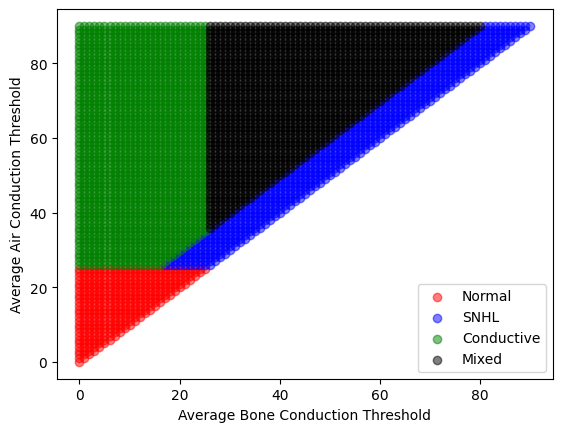

In [ ]:
fake_df_HL = HL_loss_classifier(fake_df)
HL_plot(fake_df_HL)

# Clustering based on audiometric frequencies of right ear

In [ ]:
hl_right = df[hl_right_labels]
hl_right

,R250,R500,R1000,R2000,R3000,R4000,R6000,R8000
0,55.0,60.0,60.0,60.0,50.0,45.0,50.0,55.0
1,45.0,40.0,35.0,50.0,40.0,50.0,50.0,45.0
2,20.0,15.0,15.0,15.0,20.0,25.0,30.0,25.0
3,15.0,15.0,20.0,10.0,0.0,0.0,0.0,10.0
4,15.0,15.0,10.0,5.0,10.0,15.0,15.0,30.0
...,...,...,...,...,...,...,...,...
76795,10.0,10.0,5.0,5.0,5.0,0.0,5.0,0.0
76798,40.0,40.0,50.0,60.0,75.0,85.0,80.0,80.0
76799,30.0,25.0,20.0,15.0,10.0,10.0,10.0,15.0
76802,20.0,25.0,30.0,40.0,45.0,55.0,60.0,70.0


## Kmeans clustering

In [ ]:
from sklearn.cluster import KMeans

In [ ]:
#6 clusters
n = 6
kmeans_6 = KMeans(n_clusters=n, init='k-means++', max_iter=1000, n_init=10, random_state=0)
kmeans_6.fit(hl_right) #To compute cluster centres 

KMeans(max_iter=1000, n_clusters=6, n_init=10, random_state=0)

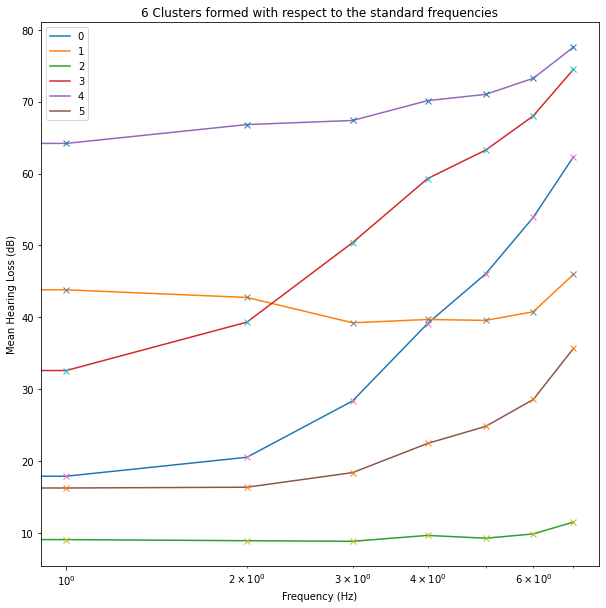

In [ ]:
"""
Fixing colours for cluster centroids (fix for maximum number of cluster that 
will be potentially formed. 
It will be easy to draw inferences from diffect clusters formed)
"""
color = plt.cm.rainbow(np.linspace(0, 1, 6))

#Plot
plt.figure(figsize=(10,10))
for i, c in zip(range(n), color):
  plt.plot(hl_right_labels, kmeans_6.cluster_centers_.T[:,i], label = i)
  plt.legend()
plt.semilogx(hl_right_labels, kmeans_6.cluster_centers_.T, 'x')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Mean Hearing Loss (dB)')
plt.title('6 Clusters formed with respect to the standard frequencies')
plt.show()

In [ ]:
#Count of number of patients in each of the cluster
predictions_6 = np.ndarray.tolist(kmeans_6.predict(hl_right))
labels = np.unique(kmeans_6.labels_)
count = {}
for i in labels:
  count_temp = predictions_6.count(i)
  count[i] = count_temp
print("For 6 clusters count:", count)

For 6 clusters count: {0: 9117, 1: 4888, 2: 14897, 3: 8210, 4: 4297, 5: 11778}


In [ ]:
"""
Obtaining the index of rows of audiogram freq samples as the values of index 
corresponding to the original index of mfb audio xlsx sheet
"""

good_index = df.index.values

In [ ]:
#Fiding the index positions of each of the cluster

index_label0 = [good_index[i] for i in range(len(predictions_6)) if predictions_6[i] == 0 ]
index_label1 = [good_index[i] for i in range(len(predictions_6)) if predictions_6[i] == 1 ]
index_label2 = [good_index[i] for i in range(len(predictions_6)) if predictions_6[i] == 2 ]
index_label3 = [good_index[i] for i in range(len(predictions_6)) if predictions_6[i] == 3 ]
index_label4 = [good_index[i] for i in range(len(predictions_6)) if predictions_6[i] == 4 ]
index_label5 = [good_index[i] for i in range(len(predictions_6)) if predictions_6[i] == 5 ]

Labelling cluster based on the following notation:

cluster_label = {4:'Low flat', 2:'Mid flat', 0:'High flat', 1:'Low slope', 3:'Mid slope', 5:'High slope'}


In [ ]:
df.loc[index_label0,'Cluster_labels'] = 'Mid Slope'
df.loc[index_label1,'Cluster_labels'] = 'Mid Flat'
df.loc[index_label2,'Cluster_labels'] = 'Low Flat'
df.loc[index_label3,'Cluster_labels'] = 'High Slope'
df.loc[index_label4,'Cluster_labels'] = 'High Flat'
df.loc[index_label5,'Cluster_labels'] = 'Low Slope'

In [ ]:
df

,AgeAtTestDate,R250,R500,R1000,R2000,R3000,R4000,R6000,R8000,L250,...,R_PTA_ABGap,R_HFPTA_ABGap,R_PTA_All_ABGap,L_PTA_ABGap,L_HFPTA_ABGap,L_PTA_All_ABGap,R_Type_HL_Mod,R_Type_HL_HF,R_Type_HL_All,Cluster_labels
0,58.0,55.0,60.0,60.0,60.0,50.0,45.0,50.0,55.0,30.0,...,46.666668,36.666664,41.25,8.333332,5.000000,7.50,Conductive,Conductive,Conductive,Mid Flat
1,37.0,45.0,40.0,35.0,50.0,40.0,50.0,50.0,45.0,40.0,...,25.000002,28.333334,26.25,15.000002,10.000000,12.50,Conductive,Conductive,Conductive,Mid Flat
2,25.0,20.0,15.0,15.0,15.0,20.0,25.0,30.0,25.0,30.0,...,10.000000,8.333334,10.00,21.666664,16.666668,20.00,Normal,Normal,Normal,Low Slope
3,49.0,15.0,15.0,20.0,10.0,0.0,0.0,0.0,10.0,5.0,...,10.000000,6.666667,7.50,3.333333,3.333333,3.75,Normal,Normal,Normal,Low Flat
4,47.0,15.0,15.0,10.0,5.0,10.0,15.0,15.0,30.0,10.0,...,1.666667,3.333333,3.75,NaN,6.666667,8.75,Normal,Normal,Normal,Low Flat
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76795,21.0,10.0,10.0,5.0,5.0,5.0,0.0,5.0,0.0,10.0,...,0.000000,-1.666667,-1.25,0.000000,0.000000,0.00,Normal,Normal,Normal,Low Flat
76798,91.0,40.0,40.0,50.0,60.0,75.0,85.0,80.0,80.0,50.0,...,NaN,NaN,NaN,0.000000,0.000000,0.00,Normal,Normal,Normal,High Slope
76799,40.0,30.0,25.0,20.0,15.0,10.0,10.0,10.0,15.0,20.0,...,3.333334,0.000000,2.50,1.666668,3.333334,3.75,Normal,Normal,Normal,Low Flat
76802,75.0,20.0,25.0,30.0,40.0,45.0,55.0,60.0,70.0,20.0,...,NaN,-8.333332,-12.50,5.000000,6.666668,5.00,Normal,SNHL,SNHL,Mid Slope


# SII

## Import the necessary packages

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import interpolate
from typing import List, Union

In [ ]:
# Download and unpack the SII code from Malcolm's private repository
!wget http://www.slaney.org/malcolm/tmp/sii.tgz
!tar xzf sii.tgz

--2023-03-03 02:05:47--  http://www.slaney.org/malcolm/tmp/sii.tgz
Resolving www.slaney.org (www.slaney.org)... 130.211.137.32
Connecting to www.slaney.org (www.slaney.org)|130.211.137.32|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11966 (12K) [application/octet-stream]
Saving to: ‘sii.tgz.2’

sii.tgz.2           100%[===================>]  11.69K  --.-KB/s    in 0.002s  

2023-03-03 02:05:47 (5.62 MB/s) - ‘sii.tgz.2’ saved [11966/11966]



In [ ]:
from speech_intelligibility_index import sii

In [ ]:
#Defining the audiogram frequencies
audiogram_freqs = [250, 500, 1000, 2000, 3000, 4000, 6000, 8000]

In [ ]:
def sii_from_audiogram(
    audiogram_samples: Union[List[float], np.ndarray],
    audiogram_freqs: Union[List[float], np.ndarray] = audiogram_freqs) -> float:
    """Compute the speech intelligibility index from from an audiogram

    Args:
      audiogram_samples: Hearing loss in db at frequencies corresponding to the 
        next argument
      audiogram_freqs: Frequencies (Hz) where audiogram is measured
    Returns:
      a float, the corresponding speech intelligibility index
    """
    audiogram_samples = np.asarray(audiogram_samples)
    audiogram_freqs = np.asarray(audiogram_freqs)
    assert audiogram_samples.ndim == 1
    assert audiogram_freqs.ndim == 1
    assert audiogram_samples.shape[0] == audiogram_freqs.shape[0]

    interp_func = interpolate.interp1d(audiogram_freqs, audiogram_samples,
                                       kind='quadratic',
                                       fill_value='extrapolate')
    sii_critical_bands = [160, 200, 250, 315, 400, 500, 630, 800, 1000, 1250, 
               1600, 2000, 2500, 3150, 4000, 5000, 6300, 8000]
    critical_band_hl = interp_func(sii_critical_bands)

    [ssl, nsl, hearing_threshold] = sii.input_5p1(ssl='normal')
    return sii.sii(ssl=ssl+25, nsl=nsl, hearing_threshold=critical_band_hl)

In [ ]:
audiogram_column_names = [f'R{f}' for f in audiogram_freqs]

In [ ]:
audiogram_samples = df.loc[:,audiogram_column_names]
audiogram_freqs, audiogram_samples.shape

([250, 500, 1000, 2000, 3000, 4000, 6000, 8000], (53187, 8))

In [ ]:
# Calculate the SII for all patients' audiograms
sii_data = np.zeros(audiogram_samples.shape[0])

for i in range(audiogram_samples.shape[0]):
  sii_data[i] = sii_from_audiogram(audiogram_samples.loc[good_index[i], :], audiogram_freqs)

In [ ]:
#Appending SII to the dataframe
df['SII'] = sii_data
df.head(10)

,AgeAtTestDate,R250,R500,R1000,R2000,R3000,R4000,R6000,R8000,L250,...,R_HFPTA_ABGap,R_PTA_All_ABGap,L_PTA_ABGap,L_HFPTA_ABGap,L_PTA_All_ABGap,R_Type_HL_Mod,R_Type_HL_HF,R_Type_HL_All,Cluster_labels,SII
0,58.0,55.0,60.0,60.0,60.0,50.0,45.0,50.0,55.0,30.0,...,36.666664,41.25,8.333332,5.000000,7.50,Conductive,Conductive,Conductive,Mid Flat,0.600679
1,37.0,45.0,40.0,35.0,50.0,40.0,50.0,50.0,45.0,40.0,...,28.333334,26.25,15.000002,10.000000,12.50,Conductive,Conductive,Conductive,Mid Flat,0.816344
2,25.0,20.0,15.0,15.0,15.0,20.0,25.0,30.0,25.0,30.0,...,8.333334,10.00,21.666664,16.666668,20.00,Normal,Normal,Normal,Low Slope,0.900780
3,49.0,15.0,15.0,20.0,10.0,0.0,0.0,0.0,10.0,5.0,...,6.666667,7.50,3.333333,3.333333,3.75,Normal,Normal,Normal,Low Flat,0.906250
4,47.0,15.0,15.0,10.0,5.0,10.0,15.0,15.0,30.0,10.0,...,3.333333,3.75,NaN,6.666667,8.75,Normal,Normal,Normal,Low Flat,0.899672
5,44.0,5.0,10.0,5.0,5.0,5.0,0.0,5.0,5.0,5.0,...,1.666667,2.50,0.000000,0.000000,0.00,Normal,Normal,Normal,Low Flat,0.906250
6,38.0,0.0,0.0,5.0,5.0,5.0,10.0,20.0,20.0,5.0,...,-1.666667,-2.50,3.333333,1.666667,0.00,Normal,Normal,Normal,Low Flat,0.905261
8,50.0,5.0,10.0,10.0,15.0,15.0,15.0,20.0,10.0,5.0,...,NaN,NaN,-1.666666,1.666666,1.25,Normal,Normal,Normal,Low Flat,0.906250
9,50.0,15.0,10.0,5.0,5.0,5.0,0.0,10.0,25.0,15.0,...,NaN,NaN,1.666667,3.333333,2.50,Normal,Normal,Normal,Low Flat,0.902467
10,30.0,25.0,30.0,30.0,15.0,10.0,20.0,25.0,25.0,10.0,...,20.000000,22.50,10.000000,8.333333,8.75,Normal,Normal,Normal,Low Slope,0.902467


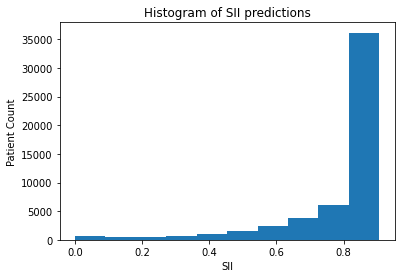

In [ ]:
plt.hist(sii_data)
plt.xlabel('SII')
plt.ylabel('Patient Count')
plt.title('Histogram of SII predictions');

#Processing clusters and HL classes

In [ ]:
class_and_cluster_strings = df[['R_Type_HL_All', 'Cluster_labels']]
class_and_cluster_strings

,R_Type_HL_All,Cluster_labels
0,Conductive,Mid Flat
1,Conductive,Mid Flat
2,Normal,Low Slope
3,Normal,Low Flat
4,Normal,Low Flat
...,...,...
76795,Normal,Low Flat
76798,Normal,High Slope
76799,Normal,Low Flat
76802,SNHL,Mid Slope


In [ ]:
set(class_and_cluster_strings.loc[:,'R_Type_HL_All']), set(class_and_cluster_strings.loc[:,'Cluster_labels'])

({'Conductive', 'Mixed', 'Normal', 'SNHL'},
 {'High Flat', 'High Slope', 'Low Flat', 'Low Slope', 'Mid Flat', 'Mid Slope'})

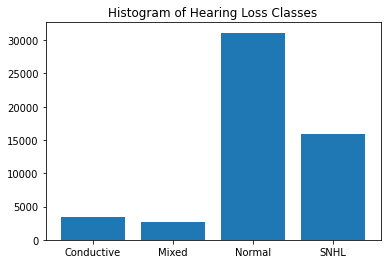

In [ ]:
# Plot the types of hearing loss
# Code from: https://stackoverflow.com/questions/28418988/how-to-make-a-histogram-from-a-list-of-strings
labels, counts = np.unique(class_and_cluster_strings.loc[:,'R_Type_HL_All'],return_counts=True)
ticks = range(len(counts))
plt.bar(ticks, counts, align='center')
plt.xticks(ticks, labels)
plt.title('Histogram of Hearing Loss Classes');

df.loc[index_label0,'Cluster_labels'] = 'Mid Slope'

df.loc[index_label1,'Cluster_labels'] = 'Mid Flat'

df.loc[index_label2,'Cluster_labels'] = 'Low Flat'

df.loc[index_label3,'Cluster_labels'] = 'High Slope'

df.loc[index_label4,'Cluster_labels'] = 'High Flat'

df.loc[index_label5,'Cluster_labels'] = 'Low Slope'

In [ ]:
df

,AgeAtTestDate,R250,R500,R1000,R2000,R3000,R4000,R6000,R8000,L250,...,R_HFPTA_ABGap,R_PTA_All_ABGap,L_PTA_ABGap,L_HFPTA_ABGap,L_PTA_All_ABGap,R_Type_HL_Mod,R_Type_HL_HF,R_Type_HL_All,Cluster_labels,SII
0,58.0,55.0,60.0,60.0,60.0,50.0,45.0,50.0,55.0,30.0,...,36.666664,41.25,8.333332,5.000000,7.50,Conductive,Conductive,Conductive,Mid Flat,0.600679
1,37.0,45.0,40.0,35.0,50.0,40.0,50.0,50.0,45.0,40.0,...,28.333334,26.25,15.000002,10.000000,12.50,Conductive,Conductive,Conductive,Mid Flat,0.816344
2,25.0,20.0,15.0,15.0,15.0,20.0,25.0,30.0,25.0,30.0,...,8.333334,10.00,21.666664,16.666668,20.00,Normal,Normal,Normal,Low Slope,0.900780
3,49.0,15.0,15.0,20.0,10.0,0.0,0.0,0.0,10.0,5.0,...,6.666667,7.50,3.333333,3.333333,3.75,Normal,Normal,Normal,Low Flat,0.906250
4,47.0,15.0,15.0,10.0,5.0,10.0,15.0,15.0,30.0,10.0,...,3.333333,3.75,NaN,6.666667,8.75,Normal,Normal,Normal,Low Flat,0.899672
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76795,21.0,10.0,10.0,5.0,5.0,5.0,0.0,5.0,0.0,10.0,...,-1.666667,-1.25,0.000000,0.000000,0.00,Normal,Normal,Normal,Low Flat,0.906250
76798,91.0,40.0,40.0,50.0,60.0,75.0,85.0,80.0,80.0,50.0,...,NaN,NaN,0.000000,0.000000,0.00,Normal,Normal,Normal,High Slope,0.507803
76799,40.0,30.0,25.0,20.0,15.0,10.0,10.0,10.0,15.0,20.0,...,0.000000,2.50,1.666668,3.333334,3.75,Normal,Normal,Normal,Low Flat,0.906250
76802,75.0,20.0,25.0,30.0,40.0,45.0,55.0,60.0,70.0,20.0,...,-8.333332,-12.50,5.000000,6.666668,5.00,Normal,SNHL,SNHL,Mid Slope,0.800670


In [ ]:
# Map the cluster and type of hearing loss strings to numbers
class_and_clusters = np.zeros(class_and_cluster_strings.shape, dtype=np.int32)
class_map = {'Normal': 0, 'Conductive': 1, 'Mixed': 2, 'SNHL': 3}
cluster_map = {'Mid Slope': 0, 'Mid Flat': 1, 'Low Flat': 2, 
               'High Slope': 3, 'High Flat': 4, 'Low Slope': 5}
for i in range(len(class_and_clusters)):
  class_and_clusters[i, 0] = class_map[class_and_cluster_strings.loc[good_index[i], 'R_Type_HL_All']]
  class_and_clusters[i, 1] = cluster_map[class_and_cluster_strings.loc[good_index[i], 'Cluster_labels']]

class_and_clusters[:10, :]

array([[1, 1],
       [1, 1],
       [0, 5],
       [0, 2],
       [0, 2],
       [0, 2],
       [0, 2],
       [0, 2],
       [0, 2],
       [0, 5]], dtype=int32)

In [ ]:
cluster_labels = ['Mid Slope', 'Mid Flat', 'Low Flat','High Slope', 'High Flat', 'Low Slope']

In [ ]:
for i in range(6):
  index = df.loc[df['Cluster_labels'] == cluster_labels[i]].index.values
  cluster_data = audiogram_samples.loc[index] 
  centers = np.mean(cluster_data, axis=0).astype(np.int32)
  print(f'{cluster_labels[i]}: \n {centers}')

Mid Slope: 
 R250     16
R500     17
R1000    20
R2000    28
R3000    39
R4000    45
R6000    53
R8000    62
dtype: int32
Mid Flat: 
 R250     42
R500     43
R1000    42
R2000    39
R3000    39
R4000    39
R6000    40
R8000    46
dtype: int32
Low Flat: 
 R250      8
R500      9
R1000     8
R2000     8
R3000     9
R4000     9
R6000     9
R8000    11
dtype: int32
High Slope: 
 R250     28
R500     32
R1000    39
R2000    50
R3000    59
R4000    63
R6000    67
R8000    74
dtype: int32
High Flat: 
 R250     60
R500     64
R1000    66
R2000    67
R3000    70
R4000    71
R6000    73
R8000    77
dtype: int32
Low Slope: 
 R250     15
R500     16
R1000    16
R2000    18
R3000    22
R4000    24
R6000    28
R8000    35
dtype: int32


Cluster Mid Slope has 9117 patients.
Cluster Mid Flat has 4888 patients.
Cluster Low Flat has 14897 patients.
Cluster High Slope has 8210 patients.
Cluster High Flat has 4297 patients.
Cluster Low Slope has 11778 patients.


(0.0, 1.0)

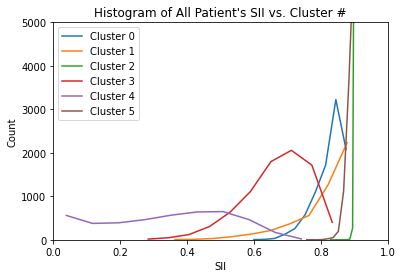

In [ ]:
# Plot the SII data versus the 6 cluster types
for i in range(6):
  index = df.loc[df['Cluster_labels'] == cluster_labels[i]].index.values 
  print(f'Cluster {cluster_labels[i]} has {index.shape[0]} patients.')
  bin_counts, bin_edges = np.histogram(df.loc[index,'SII'])
  bin_centers = (bin_edges[:-1] + bin_edges[1:])/2.0
  plt.plot(bin_centers, bin_counts)

plt.legend([f'Cluster {i}' for i in range(6)])
plt.xlabel('SII')
plt.ylabel('Count')
plt.title("Histogram of All Patient's SII vs. Cluster #")
plt.ylim([0, 5000]);   # Limit cluster 1 so graph is clearer
plt.xlim([0,1])

In [ ]:
df[np.logical_and(df.loc[:,'Cluster_labels'] == 'Mid Flat' ,df.loc[:,'R_Type_HL_All'] == 'Conductive')].index.values

array([    0,     1,    12, ..., 76426, 76600, 76675])

In [ ]:
class_map.items()

dict_items([('Normal', 0), ('Conductive', 1), ('Mixed', 2), ('SNHL', 3)])

Class Conductive loss has 574 patients
Class Mixed loss has 25 patients
Class Normal loss has 3878 patients
Class SNHL loss has 4640 patients


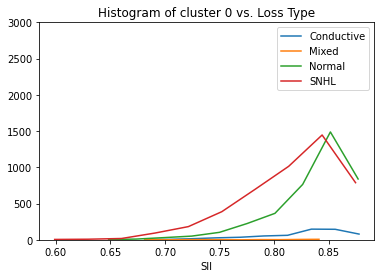

In [ ]:
# Hmmm. Cluster 0 looks interesting, so let's plot this cluster versus type of hearing loss
i = 0
loss_type = ['Conductive', 'Mixed', 'Normal', 'SNHL']
for j in range(4):
  index = df[np.logical_and(df.loc[:,'Cluster_labels'] == cluster_labels[i] ,df.loc[:,'R_Type_HL_All'] == loss_type[j])].index.values
  print(f'Class {loss_type[j]} loss has {index.shape[0]} patients')
  bin_counts, bin_edges = np.histogram(df.loc[index,'SII'])
  bin_centers = (bin_edges[:-1] + bin_edges[1:])/2.0
  plt.plot(bin_centers, bin_counts, label=loss_type[j])

plt.xlabel('SII')
plt.title(f'Histogram of cluster {i} vs. Loss Type')
plt.ylim(0,3000)
plt.legend();